# Counting Operations in BATS

Counting field arithmetic operations and column operations can be useful when investigating performance of different algorithms.

To compile BATS to count operations, you need to pass the compile flag `-DBATS_OPCOUNT` when installing BATS.
```
CFLAGS="-DBATS_OPCOUNT" python setup.py build_ext --force -j8
python setup.py install
```

Note that this currently will only work with the F2 field, and you must produce a `ReducedChainComplex` without going through the `reduce` interface.  It will also slow down the code, so it is not turned on by default.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance
import bats

np.random.seed(0)

In [2]:
bats.reset_field_ops()
bats.reset_column_ops()
bats.get_field_ops(), bats.get_column_ops()

(0, 0)

In [3]:
a = bats.F2(1)
b = a + a
bats.get_field_ops()

1

## Example with Rips Reduction

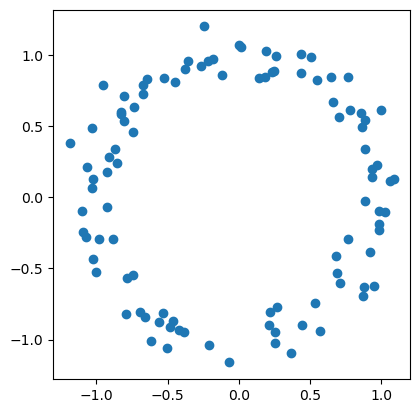

In [4]:
# first, generate a circle
n = 100
X = np.random.normal(size=(n,2))
X = X / np.linalg.norm(X, axis=1).reshape(-1,1)
X = X + np.random.normal(size=(n,2), scale = 0.1 )
fig = plt.scatter(X[:,0], X[:,1])
fig.axes.set_aspect('equal')
# plt.savefig('RipsEx_data.png')
plt.show(fig)

In [5]:
data = bats.DataSet(bats.Matrix(X)) # put into a bats.DataSet
dist = bats.Euclidean()  # distance we would like to use
F = bats.RipsFiltration(data, dist, np.inf, 2) # generate a RipsFiltration

In [6]:
bats.reset_field_ops(), bats.reset_column_ops()
C = bats.FilteredF2ChainComplex(F)
bats.get_field_ops(), bats.get_column_ops()

(0, 0)

### Options for the Reduction Algorithm

First, we'll try the standard reduction algorithm (with basis)

In [7]:
bats.reset_field_ops(), bats.reset_column_ops()
RC = bats.ReducedFilteredF2ChainComplex(C)
print("field operations: {}".format(bats.get_field_ops()))
print("column operations: {}".format(bats.get_column_ops()))

field operations: 19759887
column operations: 4984028


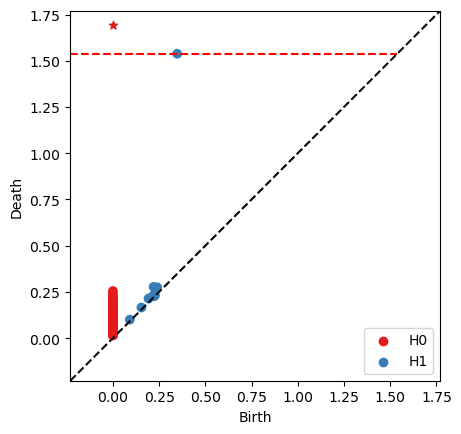

In [8]:
ps = RC.persistence_pairs(0) + RC.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()

Next the standard reduction algorithm with no basis - the column operations are cut in half.

In [9]:
bats.reset_field_ops(), bats.reset_column_ops()
RC = bats.ReducedFilteredF2ChainComplex(C, bats.standard_reduction_flag())
print("field operations: {}".format(bats.get_field_ops()))
print("column operations: {}".format(bats.get_column_ops()))

field operations: 15465396
column operations: 2492014


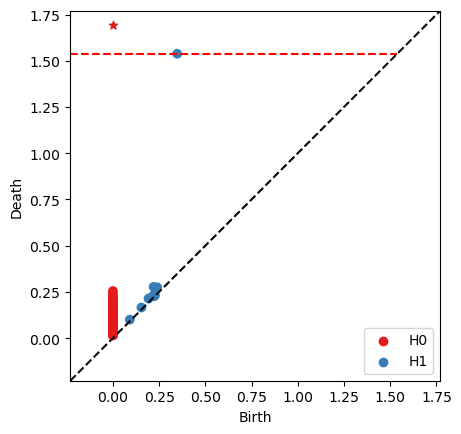

In [10]:
ps = RC.persistence_pairs(0) + RC.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()

Now, let's try the clearing optimization

In [11]:
bats.reset_field_ops(), bats.reset_column_ops()
RC = bats.ReducedFilteredF2ChainComplex(C, bats.standard_reduction_flag(), bats.clearing_flag())
print("field operations: {}".format(bats.get_field_ops()))
print("column operations: {}".format(bats.get_column_ops()))

field operations: 15341005
column operations: 2462129


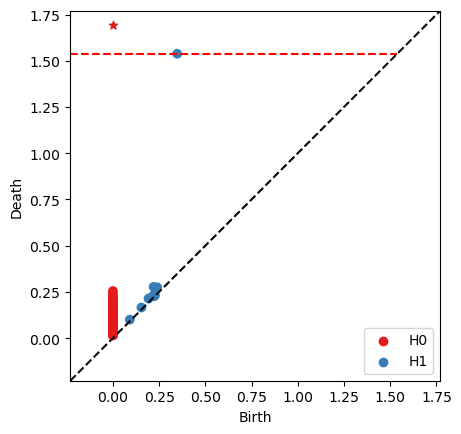

In [12]:
ps = RC.persistence_pairs(0) + RC.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()

And finally, the extra reduction flag with clearing really decreases the number of column operations

In [13]:
bats.reset_field_ops(), bats.reset_column_ops()
RC = bats.ReducedFilteredF2ChainComplex(C, bats.extra_reduction_flag(), bats.clearing_flag())
print("field operations: {}".format(bats.get_field_ops()))
print("column operations: {}".format(bats.get_column_ops()))

field operations: 19686497
column operations: 496491


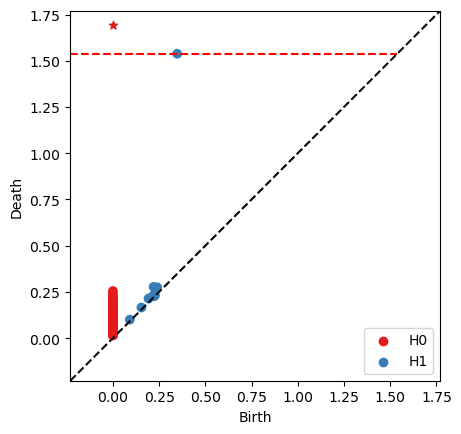

In [14]:
ps = RC.persistence_pairs(0) + RC.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()

## Example Updating Persistence

In this example, we update the level set persistence of an image

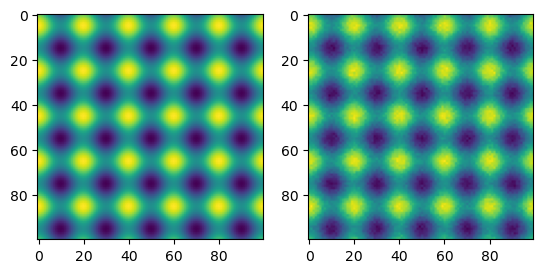

In [15]:
n = 100

img = np.empty((n,n), dtype=np.float64)
for i in range(n):
    for j in range(n):
        img[i,j] = np.sin(10* np.pi * i / n) + np.cos(10* np.pi * j/n)

img2 = img + 0.1 * np.random.randn(n,n)
fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(img2)
plt.show()

First, we compute the reduced chain complex for the original image

In [16]:
X = bats.Freudenthal(n,n)

# extend image filtration to Freudenthal triangulation
vals, imap = bats.lower_star_filtration(X, img.flatten())
F = bats.FilteredSimplicialComplex(X, vals)

bats.reset_field_ops(), bats.reset_column_ops()
C = bats.FilteredF2ChainComplex(F)
RC = bats.ReducedFilteredF2ChainComplex(C)
print("field operations: {}".format(bats.get_field_ops()))
print("column operations: {}".format(bats.get_column_ops()))

field operations: 1501302
column operations: 530266


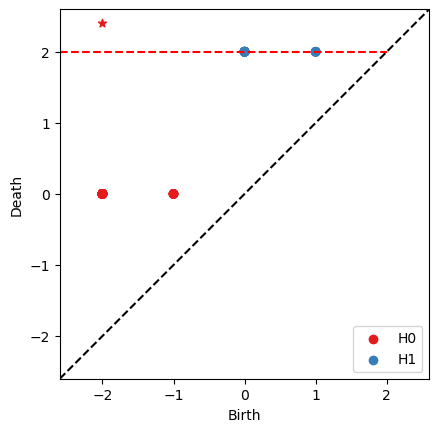

In [17]:
ps = RC.persistence_pairs(0) + RC.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()

Now, let's update persistence

In [18]:
vals, imap = bats.lower_star_filtration(X, img2.flatten())

bats.reset_field_ops(), bats.reset_column_ops()
RC.update_filtration(vals)
print("field operations: {}".format(bats.get_field_ops()))
print("column operations: {}".format(bats.get_column_ops()))

field operations: 325913
column operations: 40158


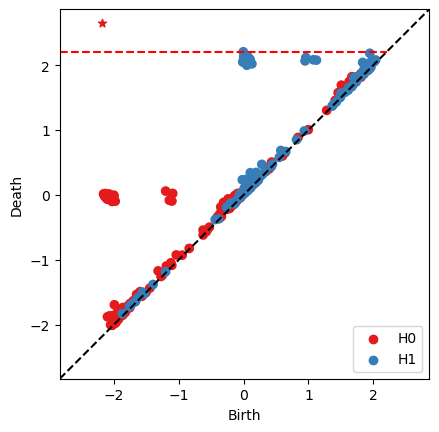

In [19]:
ps = RC.persistence_pairs(0) + RC.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()

And compare to running the updated reduction from scratch

In [20]:
bats.reset_field_ops(), bats.reset_column_ops()
vals, imap = bats.lower_star_filtration(X, img2.flatten())
F = bats.FilteredSimplicialComplex(X, vals)
C = bats.FilteredF2ChainComplex(F)
RC = bats.ReducedFilteredF2ChainComplex(C)
print("field operations: {}".format(bats.get_field_ops()))
print("column operations: {}".format(bats.get_column_ops()))

field operations: 1779741
column operations: 523044


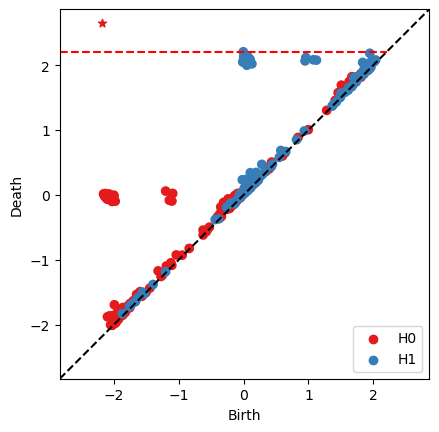

In [21]:
ps = RC.persistence_pairs(0) + RC.persistence_pairs(1)
bats.persistence_diagram(ps)
plt.show()